In [ ]:
# Clean, compatible installs (NumPy < 2 to satisfy accelerate + transformers)
!pip -q install --upgrade --no-cache-dir \
  "numpy==1.26.4" \
  "pandas==2.2.2" \
  "scikit-learn==1.5.2" \
  "transformers==4.44.2" \
  "datasets==2.21.0" \
  "evaluate==0.4.2" \
  "accelerate==0.33.0" \
  "gradio==4.44.0"


In [ ]:
!nvidia-smi -L || true
import numpy, pandas, sklearn, transformers, datasets, accelerate, gradio, sys
print("✓",
      "numpy", numpy.__version__,
      "| pandas", pandas.__version__,
      "| sklearn", sklearn.__version__,
      "| transformers", transformers.__version__,
      "| datasets", datasets.__version__,
      "| accelerate", accelerate.__version__,
      "| gradio", gradio.__version__,
      "| py", sys.version.split()[0])


GPU 0: Tesla T4 (UUID: GPU-40f8b56b-99d2-4674-6ab9-61d4ec1aeee8)
✓ numpy 1.26.4 | pandas 2.2.2 | sklearn 1.5.2 | transformers 4.44.2 | datasets 2.21.0 | accelerate 0.33.0 | gradio 4.44.0 | py 3.12.11


In [ ]:
from google.colab import files
import pandas as pd

# Upload the CSV
uploaded = files.upload()
fname = list(uploaded.keys())[0]   # get the actual uploaded filename

# Load the CSV with fallback encodings
encodings = ["utf-8","utf-8-sig","cp1252","latin1"]
df = None
for enc in encodings:
    try:
        df = pd.read_csv(fname, encoding=enc)
        print(f"✓ Loaded with encoding='{enc}'")
        break
    except Exception as e:
        print(f"Failed with {enc}: {e}")

if df is None:
    raise RuntimeError("Could not read CSV file. Check file format.")

# Normalize column names if needed
required = ["user_text","emotion","neutral_reply","empathetic_reply"]
if not set(required).issubset(df.columns):
    df = df.iloc[:, :4]
    df.columns = required

df = df.dropna(subset=["user_text","emotion"]).reset_index(drop=True)

# Preview
display(df.head(10))
print(f"Rows: {len(df)}, Columns: {list(df.columns)}")




Saving main data.csv to main data (8).csv
Failed with utf-8: 'utf-8' codec can't decode byte 0x9d in position 25: invalid start byte
Failed with utf-8-sig: 'utf-8' codec can't decode byte 0x9d in position 1182: invalid start byte
Failed with cp1252: 'charmap' codec can't decode byte 0x9d in position 1182: character maps to <undefined>
✓ Loaded with encoding='latin1'


,user_text,emotion,neutral_reply,empathetic_reply
0,I am so excited I got free shipping on my order!,excited,Fantastic! We are glad you enjoyed free shipping.,That's awesome! Free shipping always feels lik...
1,"Okay, Why can't this just work properly? Thanks.",frustrated,I hear you. Let me review your request further.,"I'm sorry this is such a hassle , let me make ..."
2,Can you resend the confirmation email for my p...,neutral,"Sure, I can help with that. Please provide mor...","Of course, I'd be glad to help. Just share a b..."
3,Why am I having to deal with this mistake again?,angry,I apologize for the error. I'll review what we...,"I'm so sorry this has happened again , I under..."
4,Can you confirm the shipping carrier for order...,neutral,I'll confirm the shipping carrier for your order.,I understand carrier details are important. I'...
5,I can't believe how poorly this was executed. ...,angry,I regret that your order was incorrect again. ...,"Thank you for telling me , I truly appreciate..."
6,I feel irritated that my invoice details are s...,frustrated,I'll review your account lock issue.,I understand repeated account locks are discou...
7,The product wasn't what I hoped for.,sad,I'm sorry to hear that. We appreciate your fee...,I know it's disappointing when expectations ar...
8,Wonderful! I am so glad the assistance team so...,happy,Wonderful! We're glad our team could help you.,"I'm so glad our team could support you,it mak..."
9,This experience has been more discouraging tha...,sad,Thank you for your feedback. I'm sorry you're ...,I'm deeply sorry this experience has caused yo...


Rows: 637, Columns: ['user_text', 'emotion', 'neutral_reply', 'empathetic_reply']


In [ ]:
#Exploring Unique Emotion Labels and Their Frequency Distribution
print("Raw unique labels (repr shows hidden spaces):")
for v in sorted(df["emotion"].dropna().unique()):
    print(repr(v))

print("\nValue counts:")
print(df["emotion"].value_counts(dropna=False))


Raw unique labels (repr shows hidden spaces):
'angry'
'excited'
'frustrated'
'happy'
'neutral'
'sad'

Value counts:
emotion
angry         113
sad           111
happy         111
excited       110
neutral       105
frustrated     87
Name: count, dtype: int64


/tmp/ipython-input-2399362893.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="emotion", palette="Set2")  # Set2, Set3, Pastel1, etc.


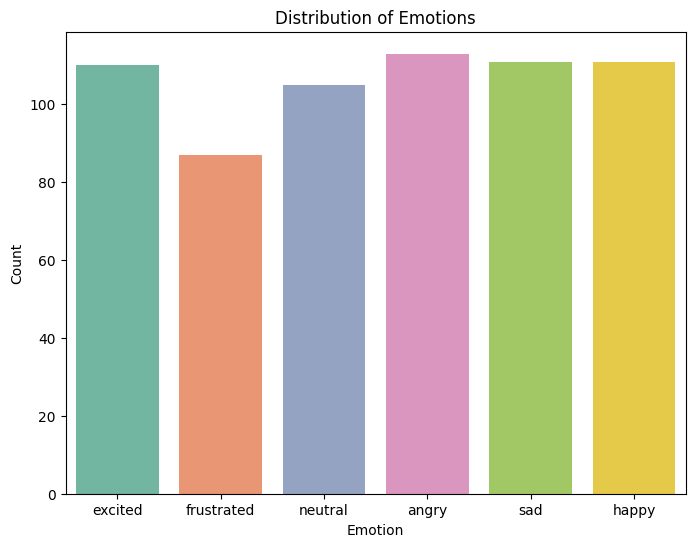

In [ ]:
#Visualization of Emotion Distribution (Count Plot)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.countplot(data=df, x="emotion", palette="Set2")  # Set2, Set3, Pastel1, etc.

plt.title("Distribution of Emotions")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()




In [ ]:
# Count total duplicates (all columns)
total_dupes = df.duplicated().sum()
print("Total duplicate rows:", total_dupes)

# Show duplicated rows
duplicates = df[df.duplicated(keep=False)]
print(duplicates)

# Count how many times each duplicate appears
dupe_counts = df.value_counts().reset_index(name="count")
dupe_counts = dupe_counts[dupe_counts["count"] > 1]
print(dupe_counts)


Total duplicate rows: 0
Empty DataFrame
Columns: [user_text, emotion, neutral_reply, empathetic_reply]
Index: []
Empty DataFrame
Columns: [user_text, emotion, neutral_reply, empathetic_reply, count]
Index: []


In [ ]:
# Check repeated user_text
dupes_user = df["user_text"].duplicated().sum()
print("Duplicate user_text count:", dupes_user)

# Show repeated ones
df["user_text"].value_counts()[df["user_text"].value_counts() > 1]


Duplicate user_text count: 0


,count
user_text,


In [ ]:
import re

def clean_label(s):
    if pd.isna(s): return s
    s = str(s)
    s = s.replace("\u200b","").replace("\xa0"," ")   # zero-width / non-breaking space
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

df["emotion"] = df["emotion"].apply(clean_label)
print("After cleaning unique labels:", sorted(df["emotion"].unique()))
print(df["emotion"].value_counts())


After cleaning unique labels: ['angry', 'excited', 'frustrated', 'happy', 'neutral', 'sad']
emotion
angry         113
sad           111
happy         111
excited       110
neutral       105
frustrated     87
Name: count, dtype: int64


In [ ]:
EXPECTED = {"angry","frustrated","sad","neutral","happy","excited"}

# See what's outside the expected set (typos like 'frustration', 'neutraal', etc.)
bad = sorted(set(df["emotion"].unique()) - EXPECTED)
print("Unexpected labels:", bad)

# (Optional) map common typos/synonyms -> expected
fix_map = {
    "frustration":"frustrated",
    "upset":"angry",
    "hapy":"happy",
    "excite":"excited",
    # add more if you spot them
}
df["emotion"] = df["emotion"].replace(fix_map)

# Recheck
print("Final labels:", sorted(df["emotion"].unique()))
print(df["emotion"].value_counts())


Unexpected labels: []
Final labels: ['angry', 'excited', 'frustrated', 'happy', 'neutral', 'sad']
emotion
angry         113
sad           111
happy         111
excited       110
neutral       105
frustrated     87
Name: count, dtype: int64


In [ ]:
# redo split after cleaning
from sklearn.model_selection import train_test_split
label_names = sorted(df["emotion"].unique())
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df["emotion"])


In [ ]:
missing = [c for c in ["angry","frustrated","sad","neutral","happy","excited"] if c not in label_names]
print("Missing classes:", missing)


Missing classes: []


In [ ]:
has_happy   = df["emotion"].str.contains(r"\bhappy\b",   na=False).sum()
has_excited = df["emotion"].str.contains(r"\bexcited\b", na=False).sum()
print("rows with 'happy':", has_happy, " | rows with 'excited':", has_excited)


rows with 'happy': 111  | rows with 'excited': 110


In [ ]:
print(df["emotion"].value_counts())


emotion
angry         113
sad           111
happy         111
excited       110
neutral       105
frustrated     87
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

label_names = sorted(df["emotion"].unique())
train_df, val_df = train_test_split(
    df, test_size=0.15, random_state=42, stratify=df["emotion"]
)

print("Classes:", label_names)


Classes: ['angry', 'excited', 'frustrated', 'happy', 'neutral', 'sad']


In [ ]:
# --- Clean labels (run once right after loading df) ---
import re, pandas as pd, numpy as np
def clean_label(s):
    if pd.isna(s): return s
    s = str(s).replace("\u200b","").replace("\xa0"," ")
    s = re.sub(r"\s+"," ", s.strip()).lower()
    return s

df["emotion"] = df["emotion"].apply(clean_label)

EXPECTED = ["angry","frustrated","sad","neutral","happy","excited"]

# --- Add seed rows for any missing classes (tiny but useful for demo) ---
seed_rows = {
    "happy": [
        ("Thanks! The product works perfectly 😄",
         "happy",
         "Glad to hear it works! If you need anything else, I'm here.",
         "That's wonderful to hear! 🎉 If there's anything more I can do, just let me know.")
    ],
    "excited": [
        ("I'm so excited to try the new feature!",
         "excited",
         "Great! You can enable the new feature from Settings > Labs.",
         "Love the excitement! 🎉 Head to Settings > Labs to turn it on—happy to guide you.")
    ],
}
for lbl in EXPECTED:
    if lbl not in set(df["emotion"].unique()):
        for (ut, em, neu, emp) in seed_rows.get(lbl, []):
            df.loc[len(df)] = [ut, em, neu, emp]

print("After seeding (if needed):")
print(df["emotion"].value_counts())

# --- Light class balancing (upsample to at least MIN_PER_CLASS) ---
MIN_PER_CLASS = 12  # adjust as you like
balanced = []
for lbl, grp in df.groupby("emotion", sort=False):
    if lbl not in EXPECTED:
        continue
    if len(grp) == 0:
        continue
    if len(grp) < MIN_PER_CLASS:
        reps = int(np.ceil(MIN_PER_CLASS / len(grp)))
        grp_aug = pd.concat([grp] * reps, ignore_index=True).iloc[:MIN_PER_CLASS]
        # tiny jitter: add a dot or exclamation randomly to user_text for variety
        grp_aug["user_text"] = grp_aug["user_text"].astype(str).apply(lambda s: s if s.endswith(("!",".")) else s + ".")
        balanced.append(grp_aug)
    else:
        balanced.append(grp)
df = pd.concat(balanced, ignore_index=True)

print("\nBalanced class counts:")
print(df["emotion"].value_counts().reindex(EXPECTED).fillna(0).astype(int))


After seeding (if needed):
emotion
angry         113
sad           111
happy         111
excited       110
neutral       105
frustrated     87
Name: count, dtype: int64

Balanced class counts:
emotion
angry         113
frustrated     87
sad           111
neutral       105
happy         111
excited       110
Name: count, dtype: int64


In [ ]:
#Data Preparation and Tokenization for DistilBERT
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DistilBertTokenizerFast

label_names = [c for c in EXPECTED if c in set(df["emotion"].unique())]
label2id = {l:i for i,l in enumerate(label_names)}
id2label = {i:l for l,i in label2id.items()}

train_df, val_df = train_test_split(
    df, test_size=0.15, random_state=42, stratify=df["emotion"]
)

MODEL_CKPT = "distilbert/distilbert-base-uncased"
tok = DistilBertTokenizerFast.from_pretrained(MODEL_CKPT)

def tok_batch(ex):
    return tok(ex["user_text"], truncation=True, padding="max_length", max_length=192)

train_ds = Dataset.from_pandas(train_df[["user_text","emotion"]].assign(label=train_df["emotion"].map(label2id)))
val_ds   = Dataset.from_pandas(val_df[["user_text","emotion"]].assign(label=val_df["emotion"].map(label2id)))

train_ds = train_ds.map(tok_batch, batched=True)
val_ds   = val_ds.map(tok_batch, batched=True)

keep = ["input_ids","attention_mask","label"]
train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in keep])
val_ds   = val_ds.remove_columns([c for c in val_ds.column_names if c not in keep])

print("Labels:", label_names, "| train:", len(train_ds), "| val:", len(val_ds))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/541 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Labels: ['angry', 'frustrated', 'sad', 'neutral', 'happy', 'excited'] | train: 541 | val: 96


In [ ]:
#Model Setup, Training Configuration, and DistilBERT Training
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer

# --- metrics without `evaluate` ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": float(accuracy_score(labels, preds)),
        "f1_macro": float(f1_score(labels, preds, average="macro"))
    }

# --- model ---
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_CKPT, num_labels=len(label_names), id2label=id2label, label2id=label2id
)

# --- trainer args ---
args = TrainingArguments(
    output_dir="distilbert_outputs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    num_train_epochs=3,
    fp16=True,                     # T4-friendly
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none"
)

# --- trainer ---
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tok,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model("distilbert_outputs/best_model")
tok.save_pretrained("distilbert_outputs/best_model")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
100,0.988100,0.607709,0.875000,0.869598


('distilbert_outputs/best_model/tokenizer_config.json',
 'distilbert_outputs/best_model/special_tokens_map.json',
 'distilbert_outputs/best_model/vocab.txt',
 'distilbert_outputs/best_model/added_tokens.json',
 'distilbert_outputs/best_model/tokenizer.json')

In [ ]:
#Model Inference and Evaluation (Classification Report & Confusion Matrix)
import torch, numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Ensure model & inputs use the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf_tok = tok
clf_mod = model.to(device).eval()

def infer(texts, batch_size=64, max_len=192):
    preds, confs = [], []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = clf_tok(batch, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
        enc = {k: v.to(device) for k, v in enc.items()}   # <<< move to same device
        with torch.no_grad():
            out = clf_mod(**enc)
            probs = torch.softmax(out.logits, dim=-1)
        preds.extend(probs.argmax(dim=-1).cpu().numpy())
        confs.extend(probs.max(dim=-1).values.cpu().numpy())
    return np.array(preds), np.array(confs)

val_texts = val_df["user_text"].tolist()
true_ids  = val_df["emotion"].map(label2id).to_numpy()
pred_ids, confs = infer(val_texts)

print(classification_report(true_ids, pred_ids, target_names=label_names, digits=3))
pd.DataFrame(confusion_matrix(true_ids, pred_ids, labels=list(range(len(label_names)))),
             index=[f"true_{l}" for l in label_names],
             columns=[f"pred_{l}" for l in label_names])


              precision    recall  f1-score   support

       angry      0.875     0.824     0.848        17
  frustrated      1.000     0.538     0.700        13
         sad      0.640     0.941     0.762        17
     neutral      1.000     1.000     1.000        16
       happy      1.000     0.882     0.938        17
     excited      0.941     1.000     0.970        16

    accuracy                          0.875        96
   macro avg      0.909     0.864     0.870        96
weighted avg      0.904     0.875     0.874        96



,pred_angry,pred_frustrated,pred_sad,pred_neutral,pred_happy,pred_excited
true_angry,14,0,3,0,0,0
true_frustrated,1,7,5,0,0,0
true_sad,1,0,16,0,0,0
true_neutral,0,0,0,16,0,0
true_happy,0,0,1,0,15,1
true_excited,0,0,0,0,0,16


In [ ]:
#Building and Saving TF-IDF Retriever with Knowledge Base Replies
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import joblib, json

kb_texts = df["user_text"].astype(str).tolist()
kb_emp   = df["empathetic_reply"].astype(str).tolist()
kb_neu   = df["neutral_reply"].astype(str).tolist()

tfidf = TfidfVectorizer(min_df=1, ngram_range=(1,2))
X = tfidf.fit_transform(kb_texts)
nn = NearestNeighbors(n_neighbors=3, metric="cosine").fit(X)

joblib.dump(tfidf, "retriever_tfidf.joblib")
joblib.dump(nn,    "retriever_nn.joblib")
with open("kb_replies.json","w",encoding="utf-8") as f:
    json.dump({"texts": kb_texts, "empathetic": kb_emp, "neutral": kb_neu}, f, ensure_ascii=False, indent=2)

print("Saved retriever: retriever_tfidf.joblib, retriever_nn.joblib, kb_replies.json")


Saved retriever: retriever_tfidf.joblib, retriever_nn.joblib, kb_replies.json


In [ ]:
#Integrating Classifier and Retriever into Chatbot Response Pipeline
import torch, json, joblib, numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# load classifier from disk
clf_tok = AutoTokenizer.from_pretrained("distilbert_outputs/best_model")
clf_mod = AutoModelForSequenceClassification.from_pretrained("distilbert_outputs/best_model").eval()

# load retriever
tfidf = joblib.load("retriever_tfidf.joblib")
nn    = joblib.load("retriever_nn.joblib")
with open("kb_replies.json","r",encoding="utf-8") as f:
    KB = json.load(f)
KB_EMP, KB_NEU = KB["empathetic"], KB["neutral"]

# id->label map (handles dict or list)
conf_id2label = clf_mod.config.id2label
id2lab = {int(k):v for k,v in conf_id2label.items()} if isinstance(conf_id2label, dict) else {i:l for i,l in enumerate(conf_id2label)}

# decision policy
ESCALATE  = {"angry","frustrated"}
CONCIERGE = {"sad"}  # offer guided flow

def classify_emotion(text):
    enc = clf_tok(text, return_tensors="pt", truncation=True, padding=True, max_length=192)
    with torch.no_grad():
        probs = torch.softmax(clf_mod(**enc).logits, dim=-1).cpu().numpy()[0]
    i = int(probs.argmax())
    return id2lab[i], float(probs[i])

def retrieve_reply(query, prefer="empathetic"):
    q = tfidf.transform([query])
    _, idx = nn.kneighbors(q, n_neighbors=1)
    best = int(idx[0][0])
    return KB_EMP[best] if prefer=="empathetic" else KB_NEU[best]

def decide_next_step(emotion, confidence):
    if (emotion in ESCALATE and confidence >= 0.55): return "escalate"
    if emotion in CONCIERGE: return "concierge"
    return "faq"

def respond(user_msg, prefer="empathetic"):
    emo, conf = classify_emotion(user_msg)
    reply = retrieve_reply(user_msg, prefer=prefer)
    step  = decide_next_step(emo, conf)
    action = ("↗️ Escalation: routing to a human agent."
              if step=="escalate" else
              "🤝 Next: I can guide you through a short troubleshooting flow or set a callback."
              if step=="concierge" else
              "📚 Next: I can link the relevant FAQ or start a checklist.")
    return f"{reply}\n\n{action}\n(emotion={emo}, confidence={conf:.2f}, step={step})"

# quick smoke test
print(respond("I'm thrilled I could track my order in real time!"))


That's wonderful! Real-time tracking can be so reassuring.

📚 Next: I can link the relevant FAQ or start a checklist.
(emotion=excited, confidence=0.80, step=faq)


In [ ]:
#Deploying the Chatbot with Gradio Interface
import gradio as gr

# Chat handler: message, history, style -> response
def chat_fn(message: str, history: list, style: str):
    # Make sure history is a list of (user, bot) tuples
    history = history or []
    answer = respond(message, prefer=style)   # respond() from earlier
    return answer

demo = gr.ChatInterface(
    fn=chat_fn,
    additional_inputs=[gr.Radio(["empathetic","neutral"], value="empathetic", label="Reply style")],
    title="Enhanced Support Chatbot",
    description="Emotion detection (DistilBERT) + empathetic retrieval + next-step decisioning."
)

demo.launch(share=True)


/usr/local/lib/python3.12/dist-packages/gradio/analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.44.0, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://eaf16b9a9e60ee76e8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
# ==== Add-on cell: lightweight HPO + plots
!pip -q install optuna > /dev/null

import optuna, math, json, pandas as pd, numpy as np, matplotlib.pyplot as plt, torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED)

In [ ]:
# 1) Define fresh model builder so Trainer can re-init per trial
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,                          # <- already defined
        num_labels=len(label_names),         # <- already defined
        id2label=id2label,                   # <- already defined
        label2id=label2id
    )


In [ ]:
# --- Small, T4-friendly hyperparameter search ---
!pip -q install optuna > /dev/null
import optuna
import torch

base_args = TrainingArguments(
    output_dir="hpo_tmp",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    seed=SEED,
    fp16=torch.cuda.is_available(),
    report_to=[],
)

trainer = Trainer(
    model_init=model_init,        # your model_init() from earlier
    args=base_args,
    train_dataset=train_ds,       # your train_ds
    eval_dataset=val_ds,          # your val_ds
    tokenizer=tok,                # your tokenizer
    compute_metrics=compute_metrics,
)

best_run = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    n_trials=10,
    hp_space=lambda trial: {
        "learning_rate": trial.suggest_float("learning_rate", 5e-6, 4e-5, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.05),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 4),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.1),
        "lr_scheduler_type": trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine"]),
    },
)

print("Best params:", best_run)


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-10-01 16:17:10,628] A new study created in memory with name: no-name-36fede73-3668-4eb2-965e-148e38157e3f
Some weights of DistilBertForSequenceClassifi

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.695831,0.468750,0.401674
2,No log,1.545074,0.625000,0.559998
3,No log,1.480769,0.666667,0.596841


[I 2025-10-01 16:17:52,195] Trial 0 finished with value: 1.2635077885077886 and parameters: {'learning_rate': 7.595934669508051e-06, 'weight_decay': 0.03694794293466702, 'num_train_epochs': 3, 'warmup_ratio': 0.08538431284065658, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 1.2635077885077886.
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.661194,0.520833,0.475364
2,No log,1.460531,0.656250,0.570314
3,No log,1.319107,0.666667,0.590564
4,No log,1.274465,0.666667,0.589379


[I 2025-10-01 16:18:52,173] Trial 1 finished with value: 1.2560457619742251 and parameters: {'learning_rate': 8.077136049969343e-06, 'weight_decay': 0.021909297840686653, 'num_train_epochs': 4, 'warmup_ratio': 0.005109589383156399, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 1.2635077885077886.
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.728088,0.364583,0.284779
2,No log,1.683614,0.489583,0.441132


[I 2025-10-01 16:19:30,965] Trial 2 finished with value: 0.9307151755273313 and parameters: {'learning_rate': 5.8548644583533585e-06, 'weight_decay': 0.043528593422325436, 'num_train_epochs': 2, 'warmup_ratio': 0.051153557251883565, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 1.2635077885077886.
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.044515,0.718750,0.644830
2,No log,0.613768,0.833333,0.818548
3,No log,0.542926,0.875000,0.867139


[I 2025-10-01 16:20:18,694] Trial 3 finished with value: 1.7421393816210888 and parameters: {'learning_rate': 3.5197288667922325e-05, 'weight_decay': 0.0006255126929782806, 'num_train_epochs': 3, 'warmup_ratio': 0.06348524887235825, 'lr_scheduler_type': 'cosine'}. Best is trial 3 with value: 1.7421393816210888.
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.430216,0.677083,0.611247
2,No log,1.059252,0.718750,0.648519
3,No log,1.001554,0.750000,0.679742


[I 2025-10-01 16:20:57,501] Trial 4 finished with value: 1.429741646408313 and parameters: {'learning_rate': 1.7453031149858436e-05, 'weight_decay': 0.045400803784215515, 'num_train_epochs': 3, 'warmup_ratio': 0.05003666027088058, 'lr_scheduler_type': 'cosine'}. Best is trial 3 with value: 1.7421393816210888.
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.691132,0.479167,0.422033


[I 2025-10-01 16:21:01,920] Trial 5 pruned. 
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.591156,0.604167,0.553523
2,No log,1.287710,0.656250,0.574700
3,No log,1.154221,0.677083,0.611316


[I 2025-10-01 16:21:28,351] Trial 6 pruned. 
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.357152,0.666667,0.607816
2,No log,1.111732,0.697917,0.632758


[I 2025-10-01 16:22:03,213] Trial 7 finished with value: 1.330674173709888 and parameters: {'learning_rate': 2.3468538005835994e-05, 'weight_decay': 0.011215727183420494, 'num_train_epochs': 2, 'warmup_ratio': 0.044976395968391904, 'lr_scheduler_type': 'linear'}. Best is trial 3 with value: 1.7421393816210888.
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.573313,0.593750,0.562366
2,No log,1.166311,0.677083,0.602075
3,No log,0.997472,0.750000,0.684822
4,No log,0.972900,0.729167,0.661633


[I 2025-10-01 16:22:57,304] Trial 8 finished with value: 1.3908000949667616 and parameters: {'learning_rate': 1.2900724568991772e-05, 'weight_decay': 0.04739097456203503, 'num_train_epochs': 4, 'warmup_ratio': 0.07532790920493893, 'lr_scheduler_type': 'cosine'}. Best is trial 3 with value: 1.7421393816210888.
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.727956,0.364583,0.270538


[I 2025-10-01 16:23:01,638] Trial 9 pruned. 


Best params: BestRun(run_id='3', objective=1.7421393816210888, hyperparameters={'learning_rate': 3.5197288667922325e-05, 'weight_decay': 0.0006255126929782806, 'num_train_epochs': 3, 'warmup_ratio': 0.06348524887235825, 'lr_scheduler_type': 'cosine'}, run_summary=None)


In [ ]:
# 3) Train once more with the best params + detailed logging for plots
final_args = TrainingArguments(
    output_dir="tuned_run",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=best_run.hyperparameters["learning_rate"],
    weight_decay=best_run.hyperparameters["weight_decay"],
    num_train_epochs=best_run.hyperparameters["num_train_epochs"],
    lr_scheduler_type=best_run.hyperparameters["lr_scheduler_type"],
    warmup_ratio=best_run.hyperparameters["warmup_ratio"],
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    seed=SEED,
    fp16=torch.cuda.is_available(),
    report_to=[],
)

final_trainer = Trainer(
    model=model_init(),       # fresh model with same head
    args=final_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tok,
    compute_metrics=compute_metrics,
)

final_trainer.train()


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.147051,0.708333,0.647391
2,1.374500,0.648916,0.843750,0.826371
3,0.608500,0.580447,0.864583,0.845594


TrainOutput(global_step=102, training_loss=0.9839320486667109, metrics={'train_runtime': 38.891, 'train_samples_per_second': 41.732, 'train_steps_per_second': 2.623, 'total_flos': 80628721691904.0, 'train_loss': 0.9839320486667109, 'epoch': 3.0})

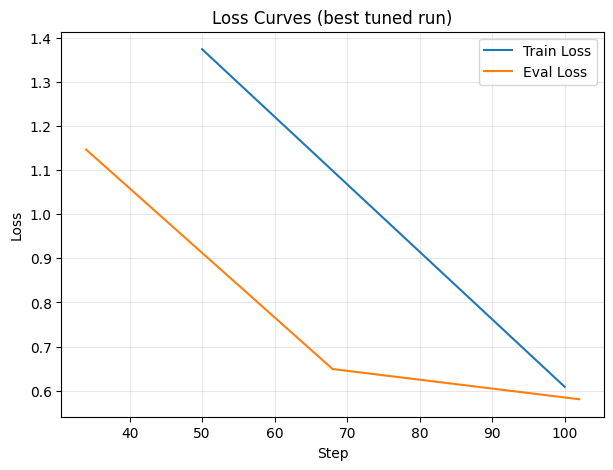

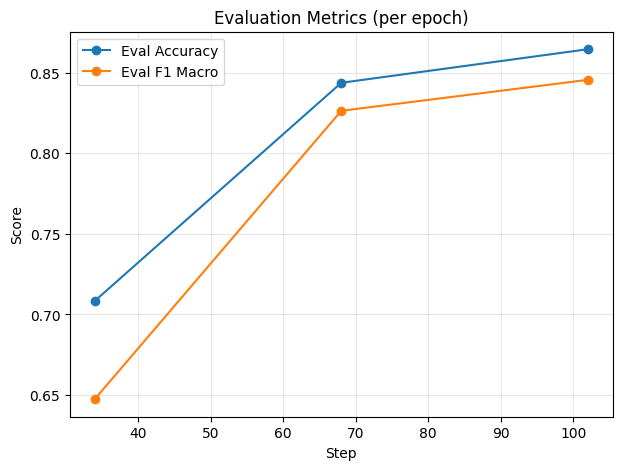

Saved: tuned_run/best_model, eval_metrics_per_epoch.csv


In [ ]:
# 4) Collect logs and make plots
logs = pd.DataFrame(final_trainer.state.log_history)
train_loss = logs[logs["loss"].notna()][["step","loss"]]
eval_logs  = logs[logs["eval_loss"].notna()][["step","eval_loss","eval_accuracy","eval_f1_macro"]]

# Save table of eval metrics per epoch
eval_logs.to_csv("eval_metrics_per_epoch.csv", index=False)

# ---- Plot: Loss curves
plt.figure(figsize=(7,5))
plt.plot(train_loss["step"], train_loss["loss"], label="Train Loss")
plt.plot(eval_logs["step"],  eval_logs["eval_loss"], label="Eval Loss")
plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Loss Curves (best tuned run)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

# ---- Plot: Accuracy & F1 per epoch
plt.figure(figsize=(7,5))
plt.plot(eval_logs["step"], eval_logs["eval_accuracy"], marker="o", label="Eval Accuracy")
plt.plot(eval_logs["step"], eval_logs["eval_f1_macro"], marker="o", label="Eval F1 Macro")
plt.xlabel("Step"); plt.ylabel("Score"); plt.title("Evaluation Metrics (per epoch)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

# 5) Save best model + tokenizer for demo
final_trainer.save_model("tuned_run/best_model")
tok.save_pretrained("tuned_run/best_model")
print("Saved: tuned_run/best_model, eval_metrics_per_epoch.csv")


In [ ]:
import torch
import numpy as np

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

# Get id↔label mapping from the saved config
id2label = {int(k): v for k, v in model.config.id2label.items()}
label2id = {v: k for k, v in id2label.items()}

def predict(texts, top_k=1, max_len=192):
    """Run inference on one string or a list of strings."""
    if isinstance(texts, str):
        texts = [texts]

    enc = tok(
        texts,
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()

    results = []
    for i, p in enumerate(probs):
        # top-k labels
        top_ids = np.argsort(-p)[:top_k]
        top = [(id2label[j], float(p[j])) for j in top_ids]
        pred_label, pred_prob = top[0]
        results.append({
            "text": texts[i],
            "pred_label": pred_label,
            "pred_prob": pred_prob,
            "top_k": top
        })
    return results

# ---- Try it ----
samples = [
    "I’m furious, this is unacceptable!",
    "I’m so happy with my purchase!",
    "I’m disappointed with the quality.",
    "Can you help me with my order?"
]
out = predict(samples, top_k=3)
for r in out:
    print(f"\nText: {r['text']}")
    print(f"Prediction: {r['pred_label']}  (p={r['pred_prob']:.3f})")
    for lbl, pr in r["top_k"]:
        print(f"  - {lbl}: {pr:.3f}")



Text: I’m furious, this is unacceptable!
Prediction: angry  (p=0.656)
  - angry: 0.656
  - excited: 0.096
  - sad: 0.094

Text: I’m so happy with my purchase!
Prediction: excited  (p=0.740)
  - excited: 0.740
  - happy: 0.144
  - angry: 0.055

Text: I’m disappointed with the quality.
Prediction: sad  (p=0.533)
  - sad: 0.533
  - angry: 0.172
  - frustrated: 0.167

Text: Can you help me with my order?
Prediction: neutral  (p=0.858)
  - neutral: 0.858
  - happy: 0.036
  - angry: 0.031


In [ ]:
# ==== Chat on your own data with the tuned model ====
import torch, numpy as np, pandas as pd, re, random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

# 1) Build a small retrieval index (TF-IDF) over your dataset's user_text
try:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
except ImportError:
    !pip -q install scikit-learn
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity

REQUIRED_COLS = {"user_text","emotion","neutral_reply","empathetic_reply"}
missing = REQUIRED_COLS - set(map(str.lower, df.columns))
# try to be robust to casing
if missing:
    df = df.rename(columns={c: c.lower() for c in df.columns})

df_chat = df[list(REQUIRED_COLS)].dropna(subset=["user_text"]).copy()
df_chat["user_text"] = df_chat["user_text"].astype(str)
df_chat["emotion"] = df_chat["emotion"].astype(str)

# optional: deduplicate identical rows to avoid repeated identical replies
df_chat = df_chat.drop_duplicates()

def normalize_text(s: str) -> str:
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s

df_chat["_norm"] = df_chat["user_text"].map(normalize_text)

vec = TfidfVectorizer(ngram_range=(1,2), min_df=1)
X = vec.fit_transform(df_chat["_norm"].tolist())

# 2) Model prediction helpers
id2label = {int(k): v for k, v in model.config.id2label.items()}

def predict_label(text, max_len=192):
    enc = tok([text], truncation=True, padding=True, max_length=max_len, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
    pid = int(np.argmax(probs))
    return id2label[pid], float(probs[pid]), probs

NEG_EMOS = {"angry","frustrated","sad"}  # adjust to your label set

def choose_style_auto(label: str) -> str:
    return "empathetic" if label.lower() in NEG_EMOS else "neutral"

# 3) Retrieve the most similar sentence(s) from your data and pick a reply
def retrieve_reply(query: str, pred_emotion: str, style: str = "auto", topn: int = 20):
    qn = normalize_text(query)
    qv = vec.transform([qn])
    sims = cosine_similarity(qv, X)[0]
    order = np.argsort(-sims)  # most similar first

    # filter primarily by the predicted emotion
    same_emo_idxs = [i for i in order if df_chat.iloc[i]["emotion"].lower() == pred_emotion.lower()]
    fallback_idxs = [i for i in order if i not in same_emo_idxs]

    pick_cols = "empathetic_reply" if style == "empathetic" else "neutral_reply"

    # search within same emotion first
    for idx in (same_emo_idxs[:topn] + fallback_idxs[:topn]):
        row = df_chat.iloc[idx]
        reply = row[pick_cols]
        if isinstance(reply, str) and reply.strip():
            return {
                "reply": reply.strip(),
                "source_user_text": row["user_text"],
                "source_emotion": row["emotion"],
                "similarity": float(sims[idx])
            }

    # if nothing valid found, return a simple fallback
    return {
        "reply": "Thanks for reaching out. I’ll look into this right away.",
        "source_user_text": None,
        "source_emotion": None,
        "similarity": 0.0
    }

# 4) One-call chatbot function
def chatbot_reply(text: str, style: str = "auto", topn: int = 20):
    pred_label, pred_prob, _ = predict_label(text)
    if style == "auto":
        style = choose_style_auto(pred_label)
    hit = retrieve_reply(text, pred_label, style, topn=topn)
    return {
        "input": text,
        "pred_label": pred_label,
        "pred_prob": pred_prob,
        "style": style,
        **hit
    }

# ---- Quick tests (edit these with your own sentences) ----
tests = [
    "I haven’t received my order and I’m really upset.",
    "Thank you—this was super fast!",
    "Why did you mess up my order again?",
    "Can you help me change the delivery address?"
]
for s in tests:
    out = chatbot_reply(s, style="auto")
    print("\nUser:", out["input"])
    print(f"→ Predicted emotion: {out['pred_label']} (p={out['pred_prob']:.3f}) | Style: {out['style']}")
    print("→ Bot reply:", out["reply"])
    if out["source_user_text"]:
        print(f"   [from similar dataset row | emotion={out['source_emotion']} | sim={out['similarity']:.3f}]")
        print(f"   matched: {out['source_user_text'][:120]}{'...' if len(out['source_user_text'])>120 else ''}")

# ---- Optional: interactive loop
# while True:
#     s = input("\nType a sentence (or 'q' to quit): ").strip()
#     if s.lower() in {"q","quit","exit"}: break
#     r = chatbot_reply(s, style="auto")
#     print(f"→ [{r['pred_label']} p={r['pred_prob']:.3f} | {r['style']}] {r['reply']}")



User: I haven’t received my order and I’m really upset.
→ Predicted emotion: sad (p=0.403) | Style: empathetic
→ Bot reply: I can imagine how disheartening this is, I'm here to help correct things.
   [from similar dataset row | emotion=sad | sim=0.207]
   matched: Okay, I'm quite upset by the results I received.

User: Thank you—this was super fast!
→ Predicted emotion: excited (p=0.613) | Style: neutral
→ Bot reply: Thank you for your kind words about our support.
   [from similar dataset row | emotion=excited | sim=0.421]
   matched: Thank you so much, the support team was super helpful!

User: Why did you mess up my order again?
→ Predicted emotion: angry (p=0.667) | Style: empathetic
→ Bot reply: I'm really sorry for this experience. I know how frustrating it must feel. We'll resolve it quickly.
   [from similar dataset row | emotion=angry | sim=1.000]
   matched: Why did you mess up my order again?

User: Can you help me change the delivery address?
→ Predicted emotion: neutral

In [ ]:
import shutil, os
bundle = "chatbot_artifacts"
os.makedirs(bundle, exist_ok=True)
shutil.copy("retriever_tfidf.joblib", bundle)
shutil.copy("retriever_nn.joblib", bundle)
shutil.copy("kb_replies.json", bundle)
shutil.copytree("distilbert_outputs/best_model", f"{bundle}/best_model", dirs_exist_ok=True)
shutil.make_archive("chatbot_artifacts_full", "zip", bundle)
print("Created chatbot_artifacts_full.zip")


Created chatbot_artifacts_full.zip
